In [52]:
#install anything needed for this colab
!pip install pycrf
!pip install sklearn-crfsuite
!pip install nltk scikit-learn pandas xgboost flask surprise seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505184 sha256=c06d7dbd1a6e4637fc30fc408ad35d1cbc639ae811e727f2324a9e6f15604c08
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [69]:
#Define all your imports over here.
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from collections import defaultdict
from flask import Flask, request, jsonify

In [58]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
#read the review file using pandas for exploratory data analysis
df_sample_reviews = pd.read_csv('/content/sample_data/sample30.csv')
df_sample_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


**1. Section Exploratory Data Analysis, and Data Cleansing**

In [10]:
df_sample_reviews.shape

(30000, 15)

In [11]:
#check the shape, datatypes, columns, and info
df_sample_reviews.dtypes

,0
id,object
brand,object
categories,object
manufacturer,object
name,object
reviews_date,object
reviews_didPurchase,object
reviews_doRecommend,object
reviews_rating,int64
reviews_text,object


In [12]:
# extracting the id, name, reviews_rating, reviews_text, reviews_username, and user_sentiment from the df_sample_reviews to a different panda dataset.
extract_review_df = df_sample_reviews[['id', 'name', 'reviews_rating', 'reviews_text', 'reviews_username', 'user_sentiment']].copy()
extract_review_df.head()

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,walker557,Negative


In [14]:
extract_review_df.count()

,0
id,30000
name,30000
reviews_rating,30000
reviews_text,30000
reviews_username,29937
user_sentiment,29999


In [17]:
# Find those reviews from the extract_review_df where the reviews_username is blank, empty, or NaN, and then remove those rows from the dataset
blank_username_rows = extract_review_df[
    extract_review_df['reviews_username'].isnull() |
    extract_review_df['reviews_username'].str.strip().eq('')
]

# Remove rows with blank usernames
extract_review_df = extract_review_df[
    ~(extract_review_df['reviews_username'].isnull() |
      extract_review_df['reviews_username'].str.strip().eq(''))
]

#Check the count of the dataframe
extract_review_df.count()


,0
id,29937
name,29937
reviews_rating,29937
reviews_text,29937
reviews_username,29937
user_sentiment,29936


In [19]:
# Find those reviews from the extract_review_df where the user_sentiment is blank, empty, or NaN, and then remove those rows from the dataset
blank_username_rows = extract_review_df[
    extract_review_df['user_sentiment'].isnull() |
    extract_review_df['user_sentiment'].str.strip().eq('')
]

# Remove rows with blank usernames
extract_review_df = extract_review_df[
    ~(extract_review_df['user_sentiment'].isnull() |
      extract_review_df['user_sentiment'].str.strip().eq(''))
]

#Check the count of the dataframe
extract_review_df.count()

,0
id,29936
name,29936
reviews_rating,29936
reviews_text,29936
reviews_username,29936
user_sentiment,29936


In [22]:
extract_review_df.head(100)

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,walker557,Negative
...,...,...,...,...,...,...
95,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,4,Really like the feel of the product and smooth...,ez42,Positive
96,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,4,In only a week I can see the difference in my ...,deedeedeedeesqr,Negative
97,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,4,Great product...no oily feeling...would recomm...,cindy1953,Positive
98,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,4,I rally enjoyed the results of this product it...,tina31,Positive


In [25]:
# Filter out rows where user_sentiment is neither 'Negative' nor 'Positive'
neither_negative_nor_positive = extract_review_df[~extract_review_df['user_sentiment'].isin(['Negative', 'Positive'])]

# Display the filtered data
neither_negative_nor_positive.head()

#Data seems to be clean

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment


In [26]:
# Filter out rows where reviews_rating is not between 1 and 5
filtered_df = extract_review_df[~extract_review_df['reviews_rating'].between(1, 5)]

# Display the filtered data
filtered_df.head()

#Data seems to be clean

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment


In [27]:
# Checking for and handle duplicate reviews
duplicate_reviews = extract_review_df[extract_review_df.duplicated(subset=['reviews_text'], keep=False)]
print(f"Number of duplicate reviews: {len(duplicate_reviews)}")

Number of duplicate reviews: 5271


In [28]:
# Removing duplicate reviews, keeping the first occurrence
extract_review_df = extract_review_df.drop_duplicates(subset=['reviews_text'], keep='first')

# Checking the shape of your cleaned dataset
extract_review_df.shape

(27227, 6)

count    27227.000000
mean       179.161678
std        181.646078
min          2.000000
25%         81.000000
50%        128.000000
75%        211.000000
max       5711.000000
Name: review_length, dtype: float64


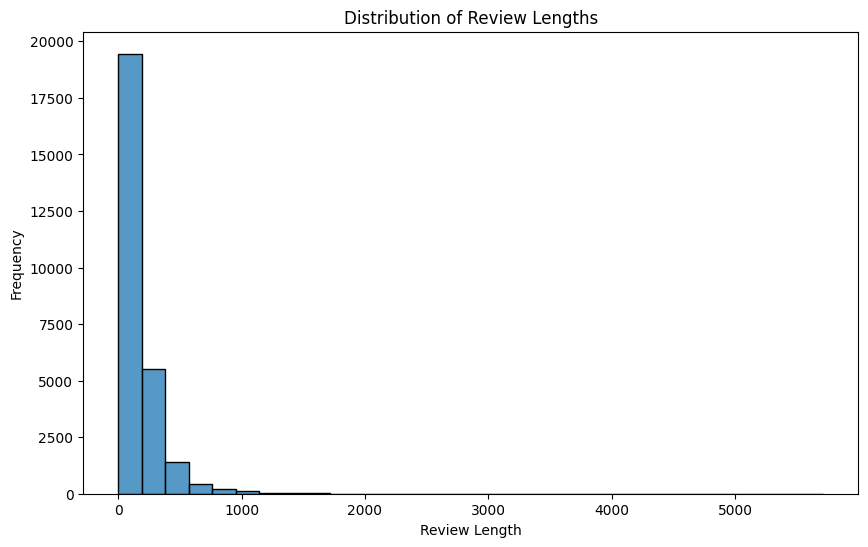

Number of short reviews: 78
Number of long reviews: 1216


In [30]:
# Analyzing review text length
extract_review_df['review_length'] = extract_review_df['reviews_text'].str.len()
print(extract_review_df['review_length'].describe())

# Visualizing review length distribution
plt.figure(figsize=(10, 6))
sns.histplot(extract_review_df['review_length'], bins=30)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Investigating very short or very long reviews – they might be noise
short_reviews = extract_review_df[extract_review_df['review_length'] < 10]
long_reviews = extract_review_df[extract_review_df['review_length'] > 500]

print(f"Number of short reviews: {len(short_reviews)}")
print(f"Number of long reviews: {len(long_reviews)}")

In [33]:
# Remove extremely short reviews
extract_review_df = extract_review_df[extract_review_df['review_length'] >= 10]

# check the data
extract_review_df.shape

(27149, 7)

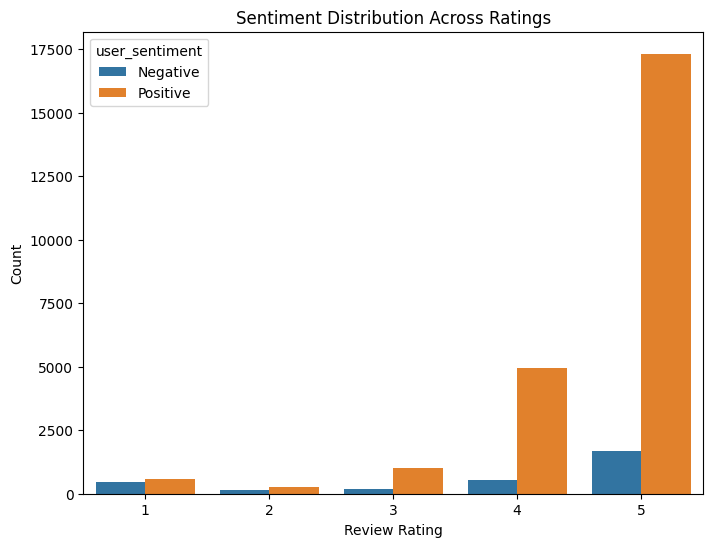

In [34]:
# Exploring the relationship between rating and sentiment
plt.figure(figsize=(8, 6))
sns.countplot(x='reviews_rating', hue='user_sentiment', data=extract_review_df)
plt.title('Sentiment Distribution Across Ratings')
plt.xlabel('Review Rating')
plt.ylabel('Count')
plt.show()

In [36]:
# Looking for inconsistencies (e.g., high rating with negative sentiment)
inconsistent_reviews = extract_review_df[
    (extract_review_df['reviews_rating'] >= 5) & (extract_review_df['user_sentiment'] == 'Negative')]
print(f"Number of inconsistent reviews: {len(inconsistent_reviews)}")

# this seems to be distortion in the data, where users have rated the product 5 but the sentiment is negative.

Number of inconsistent reviews: 1700


In [38]:
#lets a sample of such records and then we can make a decision
inconsistent_reviews.head(20)

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment,review_length
211,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,this product makes my face feel like I have de...,steph710,Negative,118
213,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,After using a short time it totally changed th...,jojo296,Negative,117
215,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,I like the feel and texture of my skin after u...,beau1230,Negative,114
216,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,"No wrinkles for me, no worrying either because...",onectmom,Negative,114
217,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,This product gives my face a starry appearance...,starlady,Negative,114
220,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,I can tell a difference when I haven't applied...,cris3686,Negative,107
235,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,I just trust it to keep my skin renewed. I see...,lillian68,Negative,196
237,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,The only product I have ever used that I could...,gatoraide1,Negative,196
246,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,I am in my seventies and get compliments all t...,darlene73,Negative,159
266,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,For deep penetrating long lasting hydration yo...,laughing2,Negative,170


In [49]:
print(inconsistent_reviews.iloc[4]['reviews_text'])
print(inconsistent_reviews.iloc[10]['reviews_text'])
print(inconsistent_reviews.iloc[420]['reviews_text'])
print(inconsistent_reviews.iloc[1225]['reviews_text'])
print(inconsistent_reviews.iloc[1500]['reviews_text'])

#based on the review texts analyzed for a sample of 6 records, there is certainly a problem with the rating vs. the user sentiment.
#while some of the review comments are positive and thus the ratings are high, but the user sentiment is noted as negative.
#for others the reviews are negative, but in that case the ratings can't be high.
#to remove noise in data, we will clean these records from the data set.

This product gives my face a starry appearance and a silky feel. This review was collected as part of a promotion.
I use this product on a daily basis. It has helped my skin feel smoother and healthier. I definitely recommend it! This review was collected as part of a promotion.
My daughter loves this
I LIVE BY THIS PRODUCT. I HAVE BLACK GREY HAIR BUT MOSTLY GREY AND THE PRODUCT ADDS SOME BLACK TO MY HAIR.
Didn't think I would like this movie but, it was awesome!p


In [50]:
# Removing inconsistent reviews from extract_review_df
extract_review_df = extract_review_df[~extract_review_df.index.isin(inconsistent_reviews.index)]
extract_review_df.shape

(25449, 7)

In [51]:
# Verifying the number of inconsistent reviews after removal
inconsistent_reviews_after_removal = extract_review_df[
    (extract_review_df['reviews_rating'] >= 5) & (extract_review_df['user_sentiment'] == 'Negative')]
print(f"Number of inconsistent reviews after removal: {len(inconsistent_reviews_after_removal)}")

Number of inconsistent reviews after removal: 0


**2. Text Pre-Processing**

In [59]:
# Text Preprocessing
def preprocess_text(text):
    """
    Preprocesses text data by:
      1. Lowercasing
      2. Removing punctuation
      3. Tokenizing
      4. Removing stop words
      5. Lemmatizing
    """
    if isinstance(text, str): # Check if text is string, handle potential NaNs or other types
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = nltk.word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return " ".join(tokens)
    else:
        return "" # Return empty string for non-string inputs

extract_review_df['processed_reviews_text'] = extract_review_df['reviews_text'].apply(preprocess_text)
print("Text Preprocessing completed. 'processed_reviews_text' column added.")
print(extract_review_df[['reviews_text', 'processed_reviews_text']].head())

Text Preprocessing completed. 'processed_reviews_text' column added.
                                        reviews_text  \
0  i love this album. it's very good. more to the...   
1  Good flavor. This review was collected as part...   
2                                       Good flavor.   
3  I read through the reviews on here before look...   
4  My husband bought this gel for us. The gel cau...   

                              processed_reviews_text  
0  love album good hip hop side current pop sound...  
1        good flavor review collected part promotion  
2                                        good flavor  
3  read review looking buying one couple lubrican...  
4  husband bought gel u gel caused irritation fel...  


In [60]:
extract_review_df.head()

,id,name,reviews_rating,reviews_text,reviews_username,user_sentiment,review_length,processed_reviews_text
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,joshua,Positive,201,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,dorothy w,Positive,62,good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,dorothy w,Positive,12,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,rebecca,Negative,696,read review looking buying one couple lubrican...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,walker557,Negative,132,husband bought gel u gel caused irritation fel...


**3. Feature Extraction**

In [61]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_features = tfidf_vectorizer.fit_transform(extract_review_df['processed_reviews_text'])
print("\nTF-IDF Feature Extraction completed.")
print("TF-IDF feature matrix shape:", tfidf_features.shape)

tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("Sample TF-IDF features:")
tfidf_df.head()


TF-IDF Feature Extraction completed.
TF-IDF feature matrix shape: (25449, 5000)
Sample TF-IDF features:


,10,100,1010,11,12,1200,13,14,1499,15,...,yummy,zac,zach,zack,zero,zilla,zinc,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# Bag of Words (Count Vectorizer)
count_vectorizer = CountVectorizer(max_features=5000) # You can adjust max_features
bow_features = count_vectorizer.fit_transform(extract_review_df['processed_reviews_text'])
print("\nBag of Words Feature Extraction completed.")
print("Bag of Words feature matrix shape:", bow_features.shape)

bow_df = pd.DataFrame(bow_features.toarray(), columns=count_vectorizer.get_feature_names_out())
print("Sample Bag of Words features:")
bow_df.head()


Bag of Words Feature Extraction completed.
Bag of Words feature matrix shape: (25449, 5000)
Sample Bag of Words features:


,10,100,1010,11,12,1200,13,14,1499,15,...,yummy,zac,zach,zack,zero,zilla,zinc,zip,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**4. Training and Evaluating Sentiment Analysis Models**

In [63]:
# Convert sentiment labels to numerical for model training
sentiment_label_mapping = {'Positive': 1, 'Negative': 0}
extract_review_df['sentiment_label_numeric'] = extract_review_df['user_sentiment'].map(sentiment_label_mapping)
extract_review_df = extract_review_df.dropna(subset=['sentiment_label_numeric']) # Drop rows with NaN in numeric sentiment (if any)
y = extract_review_df['sentiment_label_numeric'].astype(int) # Ensuring y is integer type for classification

In [64]:
#Split data for training and testing
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_features, y, test_size=0.2, random_state=42, stratify=y) # Stratify for class balance
X_train_bow, X_test_bow, _, _ = train_test_split(bow_features, y, test_size=0.2, random_state=42, stratify=y)

print("\nData split into training and testing sets.")


Data split into training and testing sets.



Training and Evaluating Logistic Regression (TF-IDF Features):
Accuracy (TF-IDF): 0.9115913555992141

Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.36      0.88      0.51       266
           1       0.99      0.91      0.95      4824

    accuracy                           0.91      5090
   macro avg       0.68      0.89      0.73      5090
weighted avg       0.96      0.91      0.93      5090



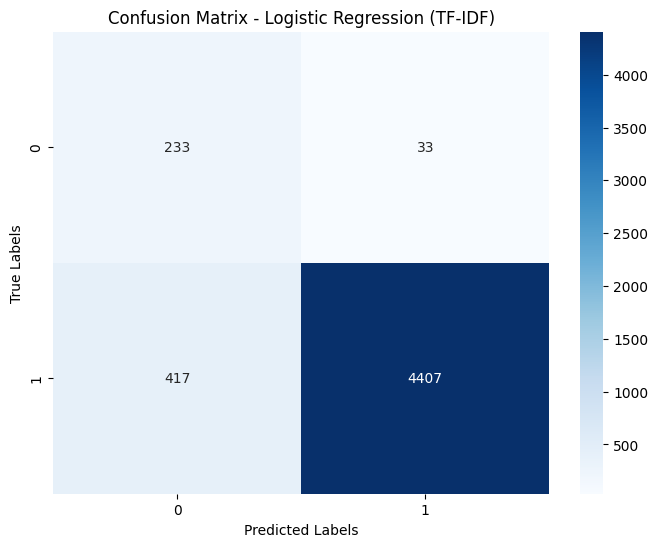

In [65]:
# Training and Evaluating Logistic Regression (TF-IDF features)
print("\nTraining and Evaluating Logistic Regression (TF-IDF Features):")
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear', class_weight='balanced') # Added class_weight for imbalance
lr_tfidf.fit(X_train_tfidf, y_train)
y_pred_lr_tfidf = lr_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_lr_tfidf))
print("\nClassification Report (TF-IDF):\n", classification_report(y_test, y_pred_lr_tfidf))
cm_lr_tfidf = confusion_matrix(y_test, y_pred_lr_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_tfidf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression (TF-IDF)')
plt.show()


Training and Evaluating Naive Bayes (Bag of Words Features):
Accuracy (BoW): 0.924950884086444

Classification Report (BoW):
               precision    recall  f1-score   support

           0       0.34      0.47      0.40       266
           1       0.97      0.95      0.96      4824

    accuracy                           0.92      5090
   macro avg       0.66      0.71      0.68      5090
weighted avg       0.94      0.92      0.93      5090



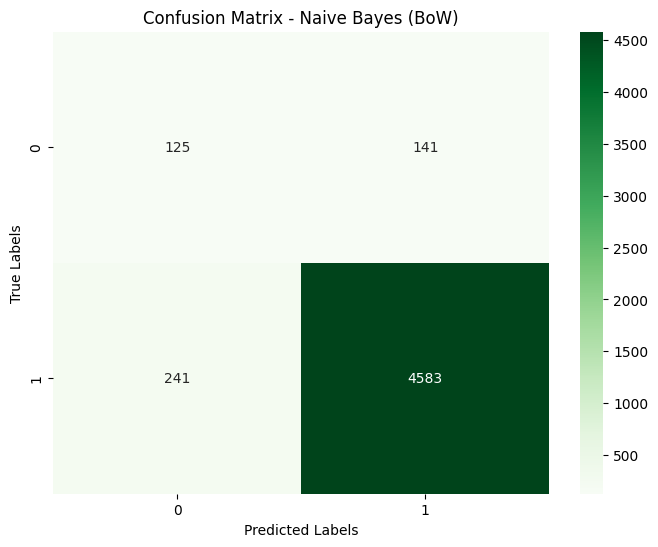

In [66]:
# Training and Evaluating Naive Bayes (Bag of Words features)
print("\nTraining and Evaluating Naive Bayes (Bag of Words Features):")
nb_bow = MultinomialNB() # Naive Bayes works better with CountVectorizer
nb_bow.fit(X_train_bow, y_train)
y_pred_nb_bow = nb_bow.predict(X_test_bow)

print("Accuracy (BoW):", accuracy_score(y_test, y_pred_nb_bow))
print("\nClassification Report (BoW):\n", classification_report(y_test, y_pred_nb_bow))
cm_nb_bow = confusion_matrix(y_test, y_pred_nb_bow)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb_bow, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Naive Bayes (BoW)')
plt.show()


Training and Evaluating XGBoost (TF-IDF Features):


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:18:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (TF-IDF): 0.9546168958742632

Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.72      0.21      0.33       266
           1       0.96      1.00      0.98      4824

    accuracy                           0.95      5090
   macro avg       0.84      0.60      0.65      5090
weighted avg       0.95      0.95      0.94      5090



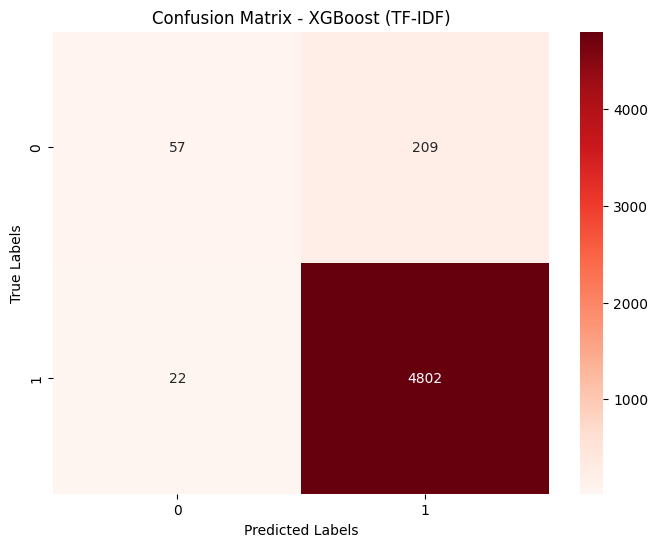

In [67]:
# Train and Evaluate XGBoost (TF-IDF features)
print("\nTraining and Evaluating XGBoost (TF-IDF Features):")
xgb_tfidf = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)
xgb_tfidf.fit(X_train_tfidf, y_train)
y_pred_xgb_tfidf = xgb_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_xgb_tfidf))
print("\nClassification Report (TF-IDF):\n", classification_report(y_test, y_pred_xgb_tfidf))
cm_xgb_tfidf = confusion_matrix(y_test, y_pred_xgb_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_tfidf, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost (TF-IDF)')
plt.show()


Training and Evaluating Random Forest (TF-IDF Features):
Accuracy (TF-IDF): 0.9536345776031434

Classification Report (TF-IDF):
               precision    recall  f1-score   support

           0       0.67      0.22      0.33       266
           1       0.96      0.99      0.98      4824

    accuracy                           0.95      5090
   macro avg       0.81      0.61      0.65      5090
weighted avg       0.94      0.95      0.94      5090



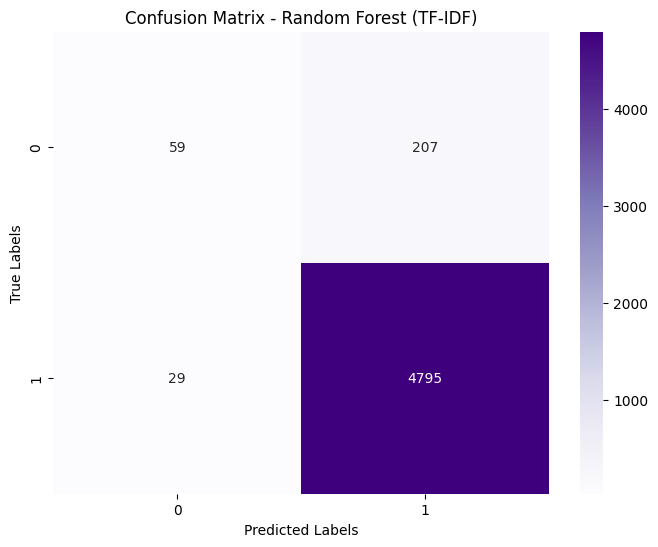

In [70]:
# Training and Evaluate Random Forest (TF-IDF features)
print("\nTraining and Evaluating Random Forest (TF-IDF Features):")
rf_tfidf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_tfidf.fit(X_train_tfidf, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test_tfidf)

print("Accuracy (TF-IDF):", accuracy_score(y_test, y_pred_rf_tfidf))
print("\nClassification Report (TF-IDF):\n", classification_report(y_test, y_pred_rf_tfidf))
cm_rf_tfidf = confusion_matrix(y_test, y_pred_rf_tfidf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_tfidf, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Random Forest (TF-IDF)')
plt.show()